# Data Science

In [1]:
#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Packages
import math
import pandas
import numpy as np
from scipy.stats.kde import gaussian_kde

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sx449_000\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sx449_000\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sx449_000\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sx449_000\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Working on Real social Network Data

## Load Data: Santa Monica
<br>
### There are only 19 hotels in my dataset, but it still took me 10 hrs to craw - some hotels have 300+ reviews while most others have below 30.

In [2]:
#Read in from pandas
hotelDf = pandas.read_csv('reviews.csv')
hotelDf.columns=['idNum','filePath','hotelName','reviewColumn','ratingScore','groundTruth']

In [3]:
hotelDf['reviewColumn'] = hotelDf['reviewColumn'].astype('str')

## Sentiment Analysis

In [4]:
reviews = hotelDf['reviewColumn'].as_matrix()

In [5]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=True, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pandas.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [6]:
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 910/910 [00:02<00:00, 320.43it/s]


In [7]:
reviewDF.head()

,reviewCol,vader
0,Fantastic place to stay. Easy walking to the P...,0.9642
1,"Staying here for three nights, April 15-18. Wh...",0.5968
2,"Great walking location to shops, restaurants a...",0.9201
3,"Hampton Inn in Santa Monica, USA, is new,clean...",0.9690
4,"We enjoyed the location, the hotel was clean a...",0.9565


In [8]:
hotelDf.head()

,idNum,filePath,hotelName,reviewColumn,ratingScore,groundTruth
0,474141020,data\ca\33052\10767402\475942232.html,Hampton Inn & Suites Los Angeles\/Santa Monica,Fantastic place to stay. Easy walking to the P...,5,positive
1,475942232,data\ca\33052\10767402\476219990.html,Hampton Inn & Suites Los Angeles\/Santa Monica,"Staying here for three nights, April 15-18. Wh...",2,negative
2,476219990,data\ca\33052\10767402\477327273.html,Hampton Inn & Suites Los Angeles\/Santa Monica,"Great walking location to shops, restaurants a...",4,positive
3,522093881,data\ca\33052\10767402\522429082.html,Hampton Inn & Suites Los Angeles\/Santa Monica,"Hampton Inn in Santa Monica, USA, is new,clean...",5,positive
4,522429082,data\ca\33052\10767402\524535104.html,Hampton Inn & Suites Los Angeles\/Santa Monica,"We enjoyed the location, the hotel was clean a...",4,positive


### Data Preprocessing
1. Find Topk words (No preprocessing steps now)
2. Reconstruct the above dataframe into CSV style..

In [9]:
# Note: You may want to use an NLTK tokenizer instead of a regular expression in the following
def dataFrameTransformation(hotelDf, reviewDF, k=500):
    reviews = reviewDF['reviewCol'].as_matrix()
    stop = set(stopwords.words('english'))
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in tokenize.regexp.regexp_tokenize(review, pattern='\w+')
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in tokenize.regexp.regexp_tokenize(reviews[i], pattern='\w+')])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [10]:
topk, finaldf = dataFrameTransformation(hotelDf, reviewDF, k=500)

In [11]:
finaldf.head()


,hotelName,ratingScore,groundTruth,reviewCol,vader,hotel,room,beach,great,staff,...,anniversary,note,completely,facing,plenty,sitting,liked,others,recently,working
0,Hampton Inn & Suites Los Angeles\/Santa Monica,5,positive,Fantastic place to stay. Easy walking to the P...,0.9642,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Hampton Inn & Suites Los Angeles\/Santa Monica,2,negative,"Staying here for three nights, April 15-18. Wh...",0.5968,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Hampton Inn & Suites Los Angeles\/Santa Monica,4,positive,"Great walking location to shops, restaurants a...",0.9201,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,Hampton Inn & Suites Los Angeles\/Santa Monica,5,positive,"Hampton Inn in Santa Monica, USA, is new,clean...",0.9690,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,Hampton Inn & Suites Los Angeles\/Santa Monica,4,positive,"We enjoyed the location, the hotel was clean a...",0.9565,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [12]:
hotels = set(finaldf['hotelName'])

## Q1: Sentiment Analysis and Aggregation

### 1.1 Vedar and Ground truth score

In [13]:
#We are only intereseted in this three column for overall analysis
itemAnalysisDf = finaldf[['hotelName','ratingScore','vader']]

In [14]:
hotelAnalysisDf = itemAnalysisDf.groupby('hotelName', as_index=True).mean()

In [15]:
# descending ratingscore idx
rating_idx = np.argsort(hotelAnalysisDf['ratingScore'])[::-1]
vader_idx = np.argsort(hotelAnalysisDf['vader'])[::-1]

In [16]:
top5_gt_hotel = hotelAnalysisDf.iloc[rating_idx].index.values[:5]
bottom_5_gt_hotel = hotelAnalysisDf.iloc[rating_idx].index.values[::-1][:5]

top5_vader_hotel = hotelAnalysisDf.iloc[vader_idx].index.values[:5]
bottom_5_vader_hotel = hotelAnalysisDf.iloc[vader_idx].index.values[::-1][:5]

In [17]:
# Avg Vader and ground truth rating per hotel
hotelAnalysisDf.iloc[vader_idx]

,ratingScore,vader
hotelName,,
Sea Shore Motel,4.111111,0.965322
Le Meridien Delfina Santa Monica,4.600000,0.949120
Courtyard by Marriott Santa Monica,4.000000,0.806450
Shutters on the Beach,4.265823,0.795868
Oceana Beach Club Hotel,4.100000,0.793650
The Ambrose,3.977273,0.788561
Hampton Inn & Suites Los Angeles\/Santa Monica,4.062500,0.787694
Viceroy Santa Monica,3.981481,0.751989
Best Western Plus Gateway Hotel Santa Monica,3.851852,0.747433


### 1.2 Top/Bottom 5 Hotels
**Top & Bottom 5 hotels: 4 out of 5 hotels matches with each other. With different orders.**


In [18]:
# top/bottom 5 hotels by Ground Truth score or by Vader score
hotel_rank_dict = {'Top5_Vader': top5_vader_hotel, 'Top5_GT': top5_gt_hotel, \
                 'Bottom5_Vader':bottom_5_vader_hotel, 'Bottom5_GT': bottom_5_gt_hotel}
hotel_rank_df = pandas.DataFrame(data=hotel_rank_dict)
hotel_rank_df

,Bottom5_GT,Bottom5_Vader,Top5_GT,Top5_Vader
0,Seaview Hotel,Ocean View Hotel,Le Meridien Delfina Santa Monica,Sea Shore Motel
1,Ocean View Hotel,Santa Monica Motel,Shutters on the Beach,Le Meridien Delfina Santa Monica
2,Santa Monica Motel,Ocean Park Inn,Sea Shore Motel,Courtyard by Marriott Santa Monica
3,Ocean Park Inn,Palihouse Santa Monica,Oceana Beach Club Hotel,Shutters on the Beach
4,Ocean Lodge Hotel,Seaview Hotel,Hampton Inn & Suites Los Angeles\/Santa Monica,Oceana Beach Club Hotel


In [19]:
finaldf_top_gt = finaldf[finaldf['hotelName']==top5_gt_hotel[0]]
finaldf_bot_gt = finaldf[finaldf['hotelName']==bottom_5_gt_hotel[0]]

In [20]:
finaldf_bot_gt

,hotelName,ratingScore,groundTruth,reviewCol,vader,hotel,room,beach,great,staff,...,anniversary,note,completely,facing,plenty,sitting,liked,others,recently,working
872,Seaview Hotel,1,negative,Just needed somewhere cheap and central in the...,0.2617,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
873,Seaview Hotel,1,negative,Must be called Seaview from before when all th...,-0.1280,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
874,Seaview Hotel,5,positive,What a privilege to have stayed at this beauti...,0.9855,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
875,Seaview Hotel,2,negative,We wanted to stay in Santa Monica and the revi...,0.8899,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
876,Seaview Hotel,4,positive,Three of us shared a two queen room - a little...,0.9914,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Q2: Frequency Analysis

### Top K words comparison between ground truth reviews and vader predicted reviews
#### Q2 Part 1
**There are locale-specific words: 'pool','parking' and 'beach'.
<br><br>
Positive: Positive words are mostly describe location, view, cleanness, and quality of service.
<br><br>
Negative: Suprisingly, there are some positive words in the list. That may indicating frequency is not a good measure for the sentiment. Because even in the negative reviews, customers still will mention 1 or 2 good points before criticizing.
**

In [21]:
#We are only intereseted in this three column for overall analysis
itemAnalysisDf = finaldf[['reviewCol','groundTruth','vader']]

In [22]:
def getTopK(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    stop.add('monica')
    stop.add('santa')
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update([word.lower() 
                            for word 
                            in tokenize.regexp.regexp_tokenize(review, pattern='\w+') 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)
    return topk

In [23]:
# Ground Truth positive or negative
topkGroundPos = getTopK(df=itemAnalysisDf, k=50, label_value='positive')
topkGroundNeg = getTopK(df=itemAnalysisDf, k=50, label_value='negative')

In [24]:
topkGroundPos

[('beach', 529),
 ('great', 523),
 ('service', 344),
 ('location', 338),
 ('pool', 303),
 ('nice', 301),
 ('would', 281),
 ('view', 271),
 ('ocean', 257),
 ('good', 248),
 ('one', 235),
 ('stayed', 216),
 ('area', 207),
 ('pier', 202),
 ('friendly', 191),
 ('well', 186),
 ('place', 182),
 ('back', 169),
 ('night', 161),
 ('comfortable', 161),
 ('also', 160),
 ('food', 160),
 ('like', 160),
 ('shutters', 155),
 ('breakfast', 154),
 ('clean', 153),
 ('time', 152),
 ('really', 149),
 ('helpful', 144),
 ('restaurant', 143),
 ('small', 141),
 ('day', 140),
 ('walk', 138),
 ('lovely', 138),
 ('beautiful', 134),
 ('excellent', 130),
 ('get', 129),
 ('front', 124),
 ('perfect', 117),
 ('wonderful', 117),
 ('could', 116),
 ('right', 115),
 ('street', 112),
 ('bar', 110),
 ('restaurants', 109),
 ('lobby', 109),
 ('recommend', 107),
 ('best', 106),
 ('little', 105),
 ('parking', 103)]

In [25]:
topkGroundNeg

[('would', 211),
 ('one', 155),
 ('night', 136),
 ('pool', 136),
 ('nice', 121),
 ('service', 121),
 ('beach', 120),
 ('location', 112),
 ('good', 110),
 ('view', 108),
 ('could', 105),
 ('day', 104),
 ('front', 103),
 ('get', 99),
 ('time', 97),
 ('great', 93),
 ('desk', 90),
 ('small', 89),
 ('check', 88),
 ('back', 88),
 ('like', 86),
 ('place', 85),
 ('stayed', 85),
 ('really', 85),
 ('ocean', 83),
 ('even', 82),
 ('parking', 78),
 ('area', 77),
 ('never', 77),
 ('two', 75),
 ('next', 70),
 ('told', 66),
 ('noise', 63),
 ('first', 62),
 ('around', 62),
 ('much', 61),
 ('well', 61),
 ('clean', 59),
 ('called', 59),
 ('however', 59),
 ('bed', 58),
 ('said', 57),
 ('breakfast', 56),
 ('booked', 56),
 ('also', 54),
 ('made', 53),
 ('another', 53),
 ('arrived', 53),
 ('went', 53),
 ('asked', 52)]

#### Q2 (b) 
**Positive: There are locale-specific phrases that are related with 'Ocean views', 'Large/Small Pool' and  'minut walk' - distance to beach, as well as 'free parking'.
<br><br>
Negative: Front desk has a high frequency in the negative reviews. There are some phrases that seems positive appears in the list, after reading the review, it shows that the positive words are used to express the gap between expectation and reality.**

In [26]:
tagger = PerceptronTagger()

# Part of Speech Tagging
# Google: https://en.wikipedia.org/wiki/Part-of-speech_tagging
pos_tag = tagger.tag

# Create phrase tree
# This grammar is described in the paper by S. N. Kim,
# T. Baldwin, and M.-Y. Kan.
# Evaluating n-gram based evaluation metrics for automatic
# keyphrase extraction.
# Technical report, University of Melbourne, Melbourne 2010.
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""
chunker = nltk.RegexpParser(grammar)

In [27]:
# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [28]:
# Noun Phrase Extraction Support Functions
stop = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stop)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

In [29]:
# Revise the previous dataframe transform function...
def newDataFrameTransformation(hotelDf, reviewDF, k=500):
    reviews = reviewDF['reviewCol'].as_matrix()
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
        counter.update(flatten([word
                        for word 
                        in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                        ]))
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [30]:
topk_phrase, finaldf_phrase = newDataFrameTransformation(hotelDf, reviewDF)

In [31]:
def getTopK_phrase(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    stop.add('monica')
    stop.add('santa')
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:
            counter.update(flatten([word for word in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review))))]))
    topk = counter.most_common(k)
    return topk

In [32]:
finaldf_phrase.head()

,hotelName,ratingScore,groundTruth,reviewCol,vader,santa monica,front desk,pool area,santa monica pier,great locat,...,sunset view,front desk clerk,good room,disappoint room,room staff,room coffe,partial sea view,shutter staff,santa monica vibe,corner suit
0,Hampton Inn & Suites Los Angeles\/Santa Monica,5,positive,Fantastic place to stay. Easy walking to the P...,0.9642,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Hampton Inn & Suites Los Angeles\/Santa Monica,2,negative,"Staying here for three nights, April 15-18. Wh...",0.5968,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Hampton Inn & Suites Los Angeles\/Santa Monica,4,positive,"Great walking location to shops, restaurants a...",0.9201,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Hampton Inn & Suites Los Angeles\/Santa Monica,5,positive,"Hampton Inn in Santa Monica, USA, is new,clean...",0.9690,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Hampton Inn & Suites Los Angeles\/Santa Monica,4,positive,"We enjoyed the location, the hotel was clean a...",0.9565,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
NPAnalysisDf = finaldf_phrase[['reviewCol','groundTruth','vader']]

In [34]:
topkGroundPos_phrase = getTopK_phrase(df=NPAnalysisDf, k=50, label_value='positive')
topkGroundNeg_phrase = getTopK_phrase(df=NPAnalysisDf, k=50, label_value='negative')

In [35]:
topkGroundPos_phrase

[('santa monica', 180),
 ('santa monica pier', 52),
 ('pool area', 43),
 ('front desk', 33),
 ('great locat', 33),
 ('venic beach', 28),
 ('ocean view', 27),
 ('ocean view room', 24),
 ('room servic', 22),
 ('shore hotel', 22),
 ('great view', 19),
 ('great place', 17),
 ('minut walk', 17),
 ('great hotel', 16),
 ('hotel staff', 15),
 ('short walk', 14),
 ('santa monica beach', 12),
 ('comfort bed', 12),
 ('night stay', 11),
 ('hotel room', 11),
 ('nice touch', 11),
 ('shangri la', 11),
 ('friendli staff', 10),
 ('custom servic', 10),
 ('lo angel', 10),
 ('great stay', 10),
 ('third street', 9),
 ('top notch', 9),
 ('first time', 9),
 ('great restaur', 9),
 ('main street', 9),
 ('free park', 9),
 ('loew santa monica', 9),
 ('beauti hotel', 8),
 ('next time', 8),
 ('street promenad', 8),
 ('first night', 8),
 ('nice hotel', 8),
 ('sea view', 8),
 ('easi access', 8),
 ('good valu', 8),
 ('bedroom suit', 8),
 ('third street promenad', 8),
 ('live room', 7),
 ('last night', 7),
 ('next tri

In [36]:
topkGroundNeg_phrase

[('santa monica', 54),
 ('front desk', 42),
 ('pool area', 19),
 ('ocean view', 11),
 ('next day', 10),
 ('nice hotel', 9),
 ('star hotel', 9),
 ('great locat', 9),
 ('shore hotel', 9),
 ('minut walk', 8),
 ('credit card', 8),
 ('last night', 8),
 ('valet park', 8),
 ('room servic', 7),
 ('first night', 7),
 ('next door', 7),
 ('ocean view room', 7),
 ('room next door', 6),
 ('santa monica pier', 6),
 ('earli check', 5),
 ('santa monica beach', 5),
 ('front desk staff', 5),
 ('dinner reserv', 5),
 ('room key', 5),
 ('lo angel', 5),
 ('first room', 5),
 ('doubl bed', 5),
 ('small pool', 5),
 ('last time', 5),
 ('traffic nois', 4),
 ('valet team', 4),
 ('long time', 4),
 ('late check', 4),
 ('hot tub', 4),
 ('good locat', 4),
 ('hour flight', 4),
 ('custom servic', 4),
 ('first day', 4),
 ('last day', 4),
 ('night stay', 4),
 ('coffe make facil', 4),
 ('ocean avenu', 4),
 ('gener manag', 4),
 ('standard room', 4),
 ('luxuri hotel', 4),
 ('next morn', 4),
 ('big porch', 4),
 ('short walk'

### Q3: Mutual Information
#### Q3 (a)
**Most words with high mutual information score contains extreme sentiments, most of them are negative. That may because negative reviews are mostly caused by certain issues, such as service, reservation, cleanness. But positive reviews may be caused by different good things.**

In [37]:
# get Top K mutual information terms from the dataframe
def getMI_phrase(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
            miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
    miScoredf = pandas.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Phrase','MI Score']
    return miScoredf

In [38]:
miScoredf = getMI_phrase(topk, finaldf)

In [39]:
miScoredf[:50]

,Phrase,MI Score
86,never,0.027355
193,money,0.024845
120,another,0.022708
240,someone,0.019899
121,called,0.019881
3,great,0.019830
2,beach,0.019705
181,checked,0.018041
54,even,0.016776
106,told,0.016601


#### Q3 (b):
**Locale specific phrase: Ocean views, Pool service.
<br><br>
Similar to the words with high mutual information score. Most phrases with high mutual information score contains extreme sentiments, most of them are negative. That may because negative reviews are mostly caused by certain issues, such as service, reservation, cleanness. But positive reviews may be caused by different good things. It's worth mentioning that front desk is a strong indicator of negative reviews**

In [40]:
# top 50 most sentiment bearing non stopwards 
miScoredf_phrase = getMI_phrase(topk_phrase, finaldf_phrase)

In [41]:
miScoredf_phrase[:50]

,Phrase,MI Score
1,front desk,0.008381
3,santa monica pier,0.007405
89,room next door,0.007073
144,room key,0.005652
222,gener manag,0.005652
193,long time,0.005652
108,last time,0.004454
26,star hotel,0.004358
32,comfort bed,0.004330
23,credit card,0.004256


### Ans: Locale specific phrase: Ocean views, Pool service. General phrase: 'Nice/poor service', 'Large/tiny room', 'sound insulation'.

### Q4: Pointwise Mutual Information
#### (a)

In [42]:
# Simple example of getting pairwise mutual information of a term
def pmiCal(df, x):
    pmilist=[]
    for i in ['positive','negative']:
        for j in [0,1]:
            px = sum(df['groundTruth']==i)/(len(df)+0.0001)
            py = sum(df[x]==j)/(len(df)+0.0001)
            pxy = len(df[(df['groundTruth']==i) & (df[x]==j)])/(len(df)+0.0001)
            if pxy==0:#Log 0 cannot happen
                pmi = math.log10((pxy+0.0001)/((px*py)+0.0001))
            else:
                pmi = math.log10(pxy/((px*py)+0.0001))
            pmilist.append([i]+[j]+[px]+[py]+[pxy]+[pmi])
    pmidf = pandas.DataFrame(pmilist)
    pmidf.columns = ['x','y','px','py','pxy','pmi']
    return pmidf

In [43]:
def pmiIndivCal(df,x,gt, label_column='groundTruth'):
    px = sum(df[label_column]==gt)/(len(df)+0.0001)
    py = sum(df[x]==1)/(len(df)+0.0001)
    pxy = len(df[(df[label_column]==gt) & (df[x]==1)])/(len(df)+0.0001)
    if pxy==0:#Log 0 cannot happen
        pmi = math.log10((pxy+0.0001)/((px*py+0.0001)+0.0001))
    else:
        pmi = math.log10(pxy/((px*py+0.0001)+0.0001))
    return pmi

In [44]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, label_column='groundTruth', topk=topk):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for word in tqdm(topk):
        pmilist.append([word[0]]+[pmiCal(df,word[0])])
        pmiposlist.append([word[0]]+[pmiIndivCal(df,word[0],'positive',label_column)])
        pmineglist.append([word[0]]+[pmiIndivCal(df,word[0],'negative',label_column)])
    pmidf = pandas.DataFrame(pmilist)
    pmiposlist = pandas.DataFrame(pmiposlist)
    pmineglist = pandas.DataFrame(pmineglist)
    pmiposlist.columns = ['word','pmi']
    pmineglist.columns = ['word','pmi']
    pmidf.columns = ['word','pmi']
    return pmiposlist, pmineglist, pmidf

In [45]:
pmiposlist, pmineglist, pmidf = pmiForAllCal(finaldf)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 18.59it/s]


In [46]:
pmiposlist.sort_values('pmi',ascending=0).head(50)

,word,pmi
458,eat,0.120252
200,highly,0.116527
306,super,0.115123
352,watch,0.107879
408,accommodating,0.107879
438,attentive,0.106683
445,pico,0.105399
103,definitely,0.104236
67,perfect,0.103046
107,amazing,0.099798


**Positive words: Sunset, eat,restaurants, view, pier, pool.**

In [47]:
#Sorted top pmi words for negative reviews
pmineglist.sort_values('pmi',ascending=0).head(50)

,word,pmi
436,dirty,0.437277
373,card,0.424490
240,someone,0.409209
193,money,0.398078
402,person,0.392907
365,poor,0.384858
277,manager,0.383693
354,reservation,0.376855
121,called,0.366722
380,heard,0.360597


**Negative words: Credit card, loud, motel, dirty, reservation.**

#### (b)

In [48]:
pmiposlist_phrase, pmineglist_phrase, pmidf_phrase = pmiForAllCal(finaldf_phrase, topk = topk_phrase)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:27<00:00, 18.02it/s]


In [49]:
# top50 noun phrase - positive
pmiposlist_phrase.sort_values('pmi',ascending=0).head(50)

,word,pmi
32,comfort bed,0.132447
45,great stay,0.130664
54,main street,0.129479
57,beauti hotel,0.128002
61,sea view,0.128002
64,bedroom suit,0.128002
69,live room,0.126111
76,amaz view,0.126111
91,pacif ocean,0.123602
96,bike path,0.123602


**Positive NP: sea view, pacif ocean, little pricey.**

In [50]:
# # top50 noun phrase - negative
pmineglist_phrase.sort_values('pmi',ascending=0).head(50)

,word,pmi
89,room next door,0.502487
144,room key,0.490096
222,gener manag,0.490096
193,long time,0.490096
279,price rang,0.470199
341,clean towel,0.470199
280,tini room,0.470199
307,new room,0.470199
369,ceil fan,0.470199
304,poor servic,0.470199


**Negative NP: room next door, traffic nois, small pool.**

### (c)

In [51]:
hotelDf_top = hotelDf[hotelDf['hotelName']=='Le Meridien Delfina Santa Monica']
hotelDf_bot = hotelDf[hotelDf['hotelName']=='Seaview Hotel']


reviewDF_top = reviewDF.iloc[hotelDf_top.index]
reviewDF_bot = reviewDF.iloc[hotelDf_bot.index]


hotelDf_top.reset_index(inplace=True)
hotelDf_bot.reset_index(inplace=True)
reviewDF_top.reset_index(inplace=True)
reviewDF_bot.reset_index(inplace=True)

topk_top_phrase, finaldf_top_phrase = newDataFrameTransformation(hotelDf_top, reviewDF_top)
topk_bot_phrase, finaldf_bot_phrase = newDataFrameTransformation(hotelDf_bot, reviewDF_bot)

In [52]:
reviewDF_bot

,index,reviewCol,vader
0,872,Just needed somewhere cheap and central in the...,0.2617
1,873,Must be called Seaview from before when all th...,-0.1280
2,874,What a privilege to have stayed at this beauti...,0.9855
3,875,We wanted to stay in Santa Monica and the revi...,0.8899
4,876,Three of us shared a two queen room - a little...,0.9914


In [53]:
pmiposlist_top_phrase, pmineglist_top_phrase, pmidf_top_phrase = pmiForAllCal(finaldf_top_phrase, topk=topk_top_phrase)
pmiposlist_bot_phrase, pmineglist_bot_phrase, pmidf_bot_phrase = pmiForAllCal(finaldf_bot_phrase, topk=topk_bot_phrase)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 55.59it/s]


In [54]:
# top 50 NP for top 1st hotel; This hotel only have positive reviews

In [55]:
pmiposlist_top_phrase.sort_values('pmi',ascending=0).head(50)

,word,pmi
0,santa monica,-0.000648
1,minut walk,-0.000648
78,great advantag,-0.001298
91,good care,-0.001298
90,beach dariu,-0.001298
89,great locat,-0.001298
88,interest spot,-0.001298
87,venic beach area,-0.001298
86,mile radiu,-0.001298
85,free courtesi car servic,-0.001298


### The top hotel is clase to the beach, at great location, confortable and have good service

In [56]:
pmiposlist_bot_phrase.sort_values('pmi',ascending=0).head(50)

,word,pmi
19,m rosa,0.396864
15,beauti quaint hotel,0.396864
36,nice place,0.396864
35,santa monica pier,0.396864
34,modern feel,0.396864
33,result stay,0.396864
32,good valu,0.396864
31,queen room,0.396864
22,seaview motel,0.396864
21,back alley,0.396864


In [57]:
pmineglist_bot_phrase.sort_values('pmi',ascending=0).head(50)

,word,pmi
14,dodgi place,0.221134
12,lumpi spongi bed,0.221134
27,small thin towel,0.221134
26,cold water,0.221134
25,second morn,0.221134
24,mere trickl,0.221134
23,poor light blockag,0.221134
30,minim addit care,0.221134
1,expens place,0.221134
29,sad part,0.221134


### It can be inferred that the hotel is old, bed is too soft, no hot water, insulation is bad, towel is thin but the price is not cheap.

### Q5: Gneral Plots

### (a).a
**Vader and Ground Truth scores mostly follows the same trend, except for hotel #8: 'Ocean View Hotel'.
This hotel have 6 ratings, out of which 4 are negative. Although the avg ratingScore is around 3, but the negative reviews are really bad. All negative reviews are lengthy and full of dissatisfaction.**

In [58]:
hotelAnalysisDf 

,ratingScore,vader
hotelName,,
Best Western Plus Gateway Hotel Santa Monica,3.851852,0.747433
Courtyard by Marriott Santa Monica,4.000000,0.806450
Hampton Inn & Suites Los Angeles\/Santa Monica,4.062500,0.787694
Hotel Shangri-La Santa Monica,3.439024,0.615015
Le Meridien Delfina Santa Monica,4.600000,0.949120
Loews Santa Monica Beach Hotel,3.905109,0.711843
Ocean Lodge Hotel,3.333333,0.645380
Ocean Park Inn,3.250000,0.475875
Ocean View Hotel,2.666667,-0.087233


In [59]:
hotel_code = dict(zip(range(len(hotels)),hotelAnalysisDf.index.values))
hotel_code

{0: 'Best Western Plus Gateway Hotel Santa Monica',
 1: 'Courtyard by Marriott Santa Monica',
 2: 'Hampton Inn & Suites Los Angeles\\/Santa Monica',
 3: 'Hotel Shangri-La Santa Monica',
 4: 'Le Meridien Delfina Santa Monica',
 5: 'Loews Santa Monica Beach Hotel',
 6: 'Ocean Lodge Hotel',
 7: 'Ocean Park Inn',
 8: 'Ocean View Hotel',
 9: 'Oceana Beach Club Hotel',
 10: 'Palihouse Santa Monica',
 11: 'Rest Haven Motel',
 12: 'Santa Monica Motel',
 13: 'Sea Shore Motel',
 14: 'Seaview Hotel',
 15: 'Shore Hotel',
 16: 'Shutters on the Beach',
 17: 'The Ambrose',
 18: 'Viceroy Santa Monica'}

In [60]:
hotelDf[hotelDf.hotelName == hotel_code[8]]

,idNum,filePath,hotelName,reviewColumn,ratingScore,groundTruth
877,256009655,data\ca\33052\81236\256257526.html,Ocean View Hotel,"The location, accommodations are fine and conv...",3,negative
878,255686148,data\ca\33052\81236\256257526.html,Ocean View Hotel,Have just returned to Australia after visiting...,3,negative
879,287750781,data\ca\33052\81236\288062725.html,Ocean View Hotel,"Reading other reviews, would have to disagree ...",4,positive
880,359928007,data\ca\33052\81236\360367369.html,Ocean View Hotel,"I stayed when they were renovating, and we wer...",1,negative
881,359393156,data\ca\33052\81236\360367369.html,Ocean View Hotel,The company I worked for booked a block of roo...,1,negative
882,538637327,data\ca\33052\81236\540023104.html,Ocean View Hotel,"Very well located, great service, everything w...",4,positive


In [61]:
review_count = finaldf.hotelName.value_counts()
review_count

Shutters on the Beach                             316
Loews Santa Monica Beach Hotel                    137
Shore Hotel                                       113
Oceana Beach Club Hotel                            70
Viceroy Santa Monica                               54
The Ambrose                                        44
Hotel Shangri-La Santa Monica                      41
Best Western Plus Gateway Hotel Santa Monica       27
Rest Haven Motel                                   16
Hampton Inn & Suites Los Angeles\/Santa Monica     16
Ocean Lodge Hotel                                  15
Le Meridien Delfina Santa Monica                   15
Santa Monica Motel                                 12
Sea Shore Motel                                     9
Palihouse Santa Monica                              8
Ocean View Hotel                                    6
Seaview Hotel                                       5
Ocean Park Inn                                      4
Courtyard by Marriott Santa 

In [62]:
def hist(hotelAnalysisDf,measure, title):
    x = list(range(len(hotels)))
    y = [hotelAnalysisDf.iloc[i][measure] for i in x]
    colors = ['red' if _y >=0 else 'pink' for _y in y]
    ax = sns.barplot(x, y, palette=colors)
    plt.title(title)
    plt.xlabel('hotel #')
    plt.ylabel(title)

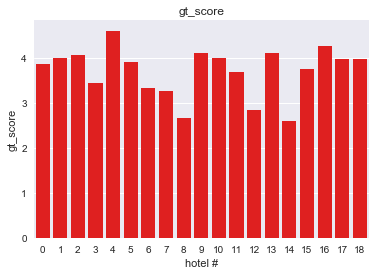

In [63]:
hist(hotelAnalysisDf,'ratingScore','gt_score')

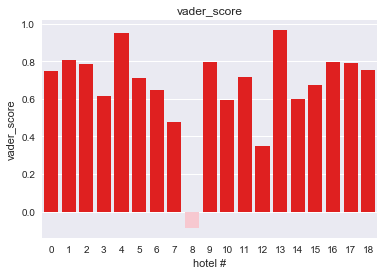

In [64]:
hist(hotelAnalysisDf,'vader','vader_score')

#### (a).b Number of reviews


**Most of hotels have less than 50 reviews, many of them only have around 10 reviews. There are some hotels have high amount of reviews, and those hotels all have relative high ratings - around 4.**

In [65]:
def reviews_num(review_count, hotel_code):
    x = list(range(len(hotels)))
    y = [review_count[hotel_code[i]] for i in x]
    colors = ['red' if _y >=0 else 'pink' for _y in y]
    ax = sns.barplot(x, y, palette=colors)
    plt.title('review_count vs. hotel #')
    plt.xlabel('hotel #')
    plt.ylabel('review_count')

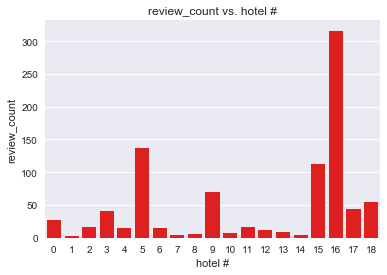

In [66]:
reviews_num(review_count, hotel_code)

### (b).a

In [67]:
hotelNames = finaldf['hotelName'].unique()
def getHotelRank(df, measure='ratingScore'):
    #Rank the hotel by ground truth rating score
    hotelRating = []
    for hotel in hotelNames:
        itemDf = df.loc[df['hotelName']==hotel]
        hotelRating.append([hotel,itemDf[measure].mean()])
    hotelRatingDfGt = pandas.DataFrame(hotelRating)
    hotelRatingDfGt.columns=['hotelName','avgRatingScore']
    hotelRatingDfGt = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0)
    return hotelRatingDfGt
hotelRatingDfGt = getHotelRank(finaldf)
hotelRatingDfVd = getHotelRank(finaldf, measure='vader')

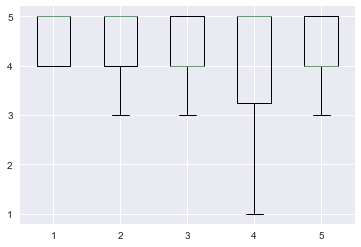

In [68]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0).head(5)
tp5gthotel['hotelName'].as_matrix()

rank1 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[0]]['ratingScore']
rank2 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[1]]['ratingScore']
rank3 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[2]]['ratingScore']
rank4 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[3]]['ratingScore']
rank5 = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].as_matrix()[4]]['ratingScore']

data = [rank1, rank2, rank3, rank4, rank5]
# multiple box plots on one figure
plt.figure()
plt.yticks(range(1,6))
plt.boxplot(data)
plt.show()

In [69]:
def stats(data):
    values =[]
    for each in data:
        values.append([each.mean(),each.var()])
    values_df = pandas.DataFrame(values)
    values_df.columns = ['mean','variance']
    return values_df

In [70]:
gt_stats_df = stats(data)
gt_stats_df

,mean,variance
0,4.600000,0.257143
1,4.265823,1.135463
2,4.111111,0.611111
3,4.100000,1.424638
4,4.062500,1.395833


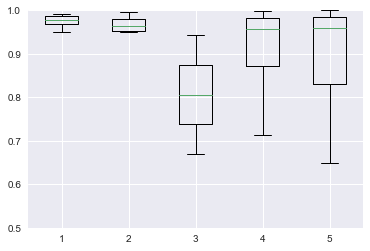

In [71]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5vdhotel = hotelRatingDfVd.sort_values('avgRatingScore',ascending=0).head(5)
tp5vdhotel['hotelName'].as_matrix()

r1 = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].as_matrix()[0]]['vader']
r2 = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].as_matrix()[1]]['vader']
r3 = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].as_matrix()[2]]['vader']
r4 = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].as_matrix()[3]]['vader']
r5 = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].as_matrix()[4]]['vader']

data_vd = [r1, r2, r3, r4, r5]
# multiple box plots on one figure
plt.figure()
plt.ylim([0.5,1])
plt.boxplot(data_vd)
plt.show()

In [72]:
vd_stats_df = stats(data_vd)
vd_stats_df

,mean,variance
0,0.965322,0.001250
1,0.949120,0.002559
2,0.806450,0.037019
3,0.795868,0.174367
4,0.793650,0.141498


Boxplot is more informative. The table only shows the means and variance. The boxplot shows max, min, 25% quartile, 75% quartile and the median value. From the boxplot, we can easily visualize the distribution of the data.

### (c).a
**The trend is that high ground truth rating score usually means high vader scores, lower ground truth score usually means with low vader socre. However, average ground truth ratings may have either high or low vader socres. That's may because neutral reviews will contain both positive and negative sentiments.**

In [73]:
y = finaldf['ratingScore'].as_matrix()
x = finaldf['vader'].as_matrix()
def scatter(x,y,x_label,y_label):
    plt.plot(x, y,"o")
    if max(x)>1000:
        plt.xlim([0,1000])
    plt.ylabel(y_label)
    plt.xlabel(x_label)

In [74]:
y.shape

(910,)

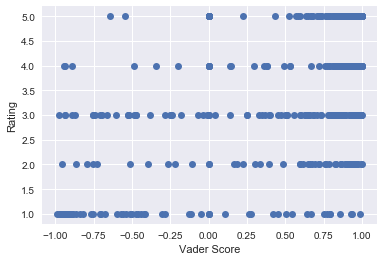

In [75]:
scatter(x,y,x_label='Vader Score',y_label='Rating')

In [76]:
def heatmap(x,y,x_label='Vader Score', y_label='Rating'):
    k = gaussian_kde(np.vstack([x, y]))
    xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    fig = plt.figure(figsize=(6,8))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)

    ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
    ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

    ax1.set_xlim(x.min(), x.max())
    ax1.set_ylim(y.min(), y.max())
    ax2.set_xlim(x.min(), x.max())
    ax2.set_ylim(y.min(), y.max())


    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)

    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)

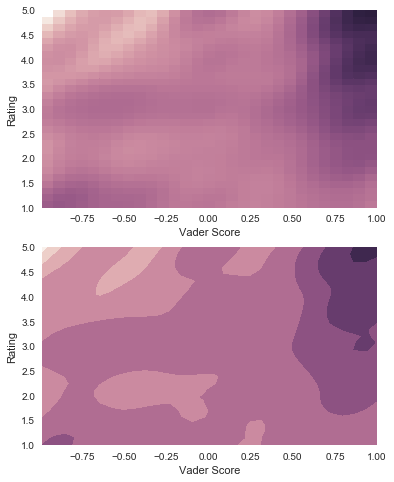

In [77]:
heatmap(x,y)

### (c).b
**The trend is that the review length are longer for hotels with high or low vader scores. However, hotels with average vader score tend to have shorter review length.**

In [78]:
length_arr = np.array([len(x.split()) for x in finaldf['reviewCol']])

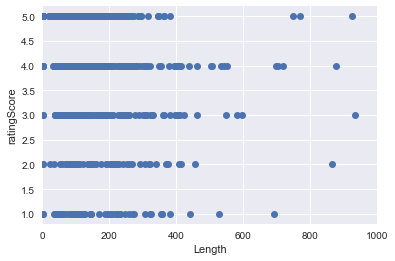

In [79]:
scatter(length_arr,y,x_label='Length',y_label='ratingScore')

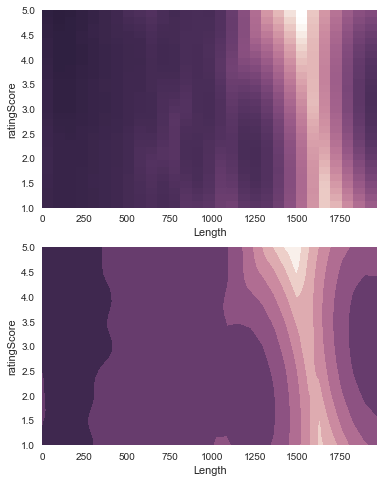

In [80]:
heatmap(length_arr,y, x_label='Length',y_label='ratingScore')

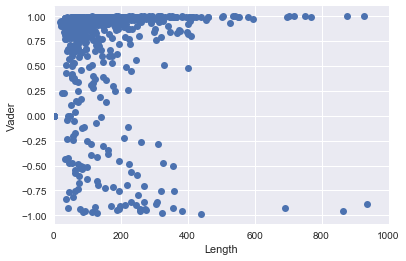

In [81]:
scatter(length_arr,x,x_label='Length',y_label='Vader')

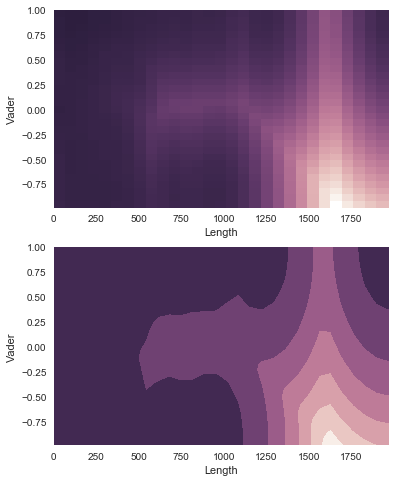

In [82]:
heatmap(length_arr,x, x_label='Length',y_label='Vader')

### (c).c

**Hotels with better ratingScore or vader score are more likely to have more reviews**

In [83]:
hotel_code

{0: 'Best Western Plus Gateway Hotel Santa Monica',
 1: 'Courtyard by Marriott Santa Monica',
 2: 'Hampton Inn & Suites Los Angeles\\/Santa Monica',
 3: 'Hotel Shangri-La Santa Monica',
 4: 'Le Meridien Delfina Santa Monica',
 5: 'Loews Santa Monica Beach Hotel',
 6: 'Ocean Lodge Hotel',
 7: 'Ocean Park Inn',
 8: 'Ocean View Hotel',
 9: 'Oceana Beach Club Hotel',
 10: 'Palihouse Santa Monica',
 11: 'Rest Haven Motel',
 12: 'Santa Monica Motel',
 13: 'Sea Shore Motel',
 14: 'Seaview Hotel',
 15: 'Shore Hotel',
 16: 'Shutters on the Beach',
 17: 'The Ambrose',
 18: 'Viceroy Santa Monica'}

In [84]:
review_count

Shutters on the Beach                             316
Loews Santa Monica Beach Hotel                    137
Shore Hotel                                       113
Oceana Beach Club Hotel                            70
Viceroy Santa Monica                               54
The Ambrose                                        44
Hotel Shangri-La Santa Monica                      41
Best Western Plus Gateway Hotel Santa Monica       27
Rest Haven Motel                                   16
Hampton Inn & Suites Los Angeles\/Santa Monica     16
Ocean Lodge Hotel                                  15
Le Meridien Delfina Santa Monica                   15
Santa Monica Motel                                 12
Sea Shore Motel                                     9
Palihouse Santa Monica                              8
Ocean View Hotel                                    6
Seaview Hotel                                       5
Ocean Park Inn                                      4
Courtyard by Marriott Santa 

In [85]:
hotelAnalysisDf

,ratingScore,vader
hotelName,,
Best Western Plus Gateway Hotel Santa Monica,3.851852,0.747433
Courtyard by Marriott Santa Monica,4.000000,0.806450
Hampton Inn & Suites Los Angeles\/Santa Monica,4.062500,0.787694
Hotel Shangri-La Santa Monica,3.439024,0.615015
Le Meridien Delfina Santa Monica,4.600000,0.949120
Loews Santa Monica Beach Hotel,3.905109,0.711843
Ocean Lodge Hotel,3.333333,0.645380
Ocean Park Inn,3.250000,0.475875
Ocean View Hotel,2.666667,-0.087233


In [86]:
num_reviews = np.array([review_count[hotel_code[x]] for x in range(len(hotels))])
gt_score = np.array([hotelAnalysisDf.loc[hotel_code[x]]['ratingScore'] for x in range(len(hotels))])
vd_score = np.array([hotelAnalysisDf.loc[hotel_code[x]]['vader'] for x in range(len(hotels))])

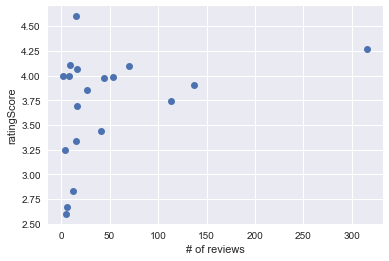

In [87]:
scatter(num_reviews,gt_score,x_label='# of reviews',y_label='ratingScore')

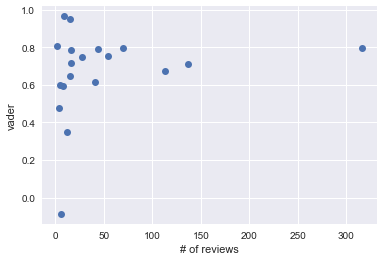

In [88]:
scatter(num_reviews,vd_score,x_label='# of reviews',y_label='vader')